In [1]:
import os
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
df = pd.read_parquet("../data/processed_emoji_dataset.parquet")
df["combined_embedding"] = df["combined_embedding"].apply(lambda x: np.array(x, dtype=np.float32))

# Split dataset into training (80%) and validation (20%)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

Using device: cuda


In [3]:
class EmojiDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text_embedding = torch.tensor(self.dataframe.iloc[idx]["combined_embedding"]).float()
        image_tensor = torch.load(self.dataframe.iloc[idx]["image_path"]).float()
        
        return text_embedding, image_tensor

# Create DataLoaders
train_dataset = EmojiDataset(train_df)
val_dataset = EmojiDataset(val_df)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print("Datasets loaded successfully!")

Datasets loaded successfully!


In [4]:
class ConditionalUNet(nn.Module):
    def __init__(self, embedding_dim=384):  # Updated to match dataset embeddings
        super(ConditionalUNet, self).__init__()
        self.embedding_projection = nn.Linear(embedding_dim, 256)  # Project text embeddings

        self.encoder1 = self.conv_block(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = self.conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = self.conv_block(128, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(128 + 128, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(64 + 64, 64)

        self.final_conv = nn.Conv2d(64, 3, kernel_size=1)

    @staticmethod
    def conv_block(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )
    
    def forward(self, x, embedding):
        emb = self.embedding_projection(embedding).unsqueeze(-1).unsqueeze(-1)
        emb = emb.expand(-1, -1, x.shape[2] // 4, x.shape[3] // 4)  # Adjust embedding size

        enc1 = self.encoder1(x)
        x = self.pool1(enc1)
        enc2 = self.encoder2(x)
        x = self.pool2(enc2)

        x = self.bottleneck(x)
        x = x + emb  # Now properly aligned
        x = self.up2(x)
        x = torch.cat([x, enc2], dim=1)
        x = self.decoder2(x)
        x = self.up1(x)
        x = torch.cat([x, enc1], dim=1)
        x = self.decoder1(x)
        return self.final_conv(x)




In [5]:
# Diffusion Model Class
class DiffusionModel:
    def __init__(self, timesteps=1000):
        self.timesteps = timesteps
        self.beta = (1 - torch.cos(torch.linspace(0, np.pi, timesteps))).to(device)  # Cosine schedule
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
    
    def add_noise(self, images, t):
        noise = torch.randn_like(images)
        alpha_bar_t = self.alpha_bar[t].view(-1, 1, 1, 1)
        noisy_images = torch.sqrt(alpha_bar_t) * images + torch.sqrt(1 - alpha_bar_t) * noise
        return noisy_images, noise
    
    def sample(self, model, shape, text_embeddings):
        x = torch.randn(shape).to(device)
        for t in reversed(range(self.timesteps)):
            with torch.no_grad():
                noise_pred = model(x, text_embeddings)
                beta_t = self.beta[t].view(1, 1, 1, 1)
                alpha_t = self.alpha[t].view(1, 1, 1, 1)
                alpha_bar_t = self.alpha_bar[t].view(1, 1, 1, 1)
                x = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * noise_pred)
                if t > 0:
                    z = torch.randn_like(x)
                    x = x + torch.sqrt(beta_t) * z
        return x

Epoch 1: 100%|██████████| 157/157 [00:07<00:00, 20.34it/s]


Epoch 1, Average Loss: 0.453634


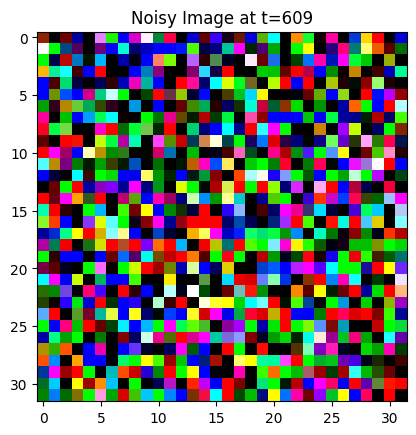

Epoch 2: 100%|██████████| 157/157 [00:07<00:00, 20.70it/s]


Epoch 2, Average Loss: 0.100581


Epoch 3: 100%|██████████| 157/157 [00:07<00:00, 21.32it/s]


Epoch 3, Average Loss: 0.090850


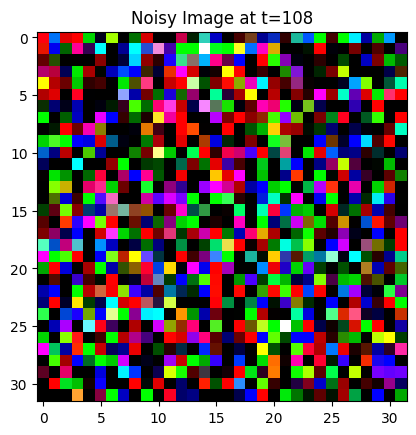

Epoch 4: 100%|██████████| 157/157 [00:07<00:00, 21.36it/s]


Epoch 4, Average Loss: 0.084135


Epoch 5: 100%|██████████| 157/157 [00:07<00:00, 21.47it/s]


Epoch 5, Average Loss: 0.072973


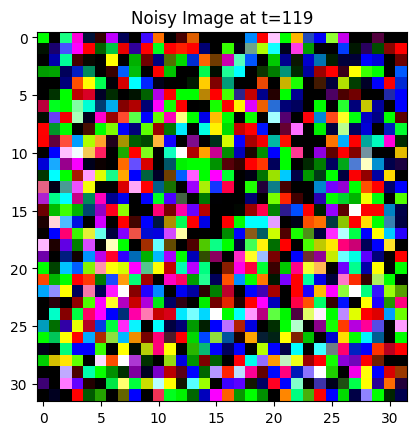

Epoch 6: 100%|██████████| 157/157 [00:07<00:00, 21.17it/s]


Epoch 6, Average Loss: 0.060197


Epoch 7: 100%|██████████| 157/157 [00:07<00:00, 21.02it/s]


Epoch 7, Average Loss: 0.057467


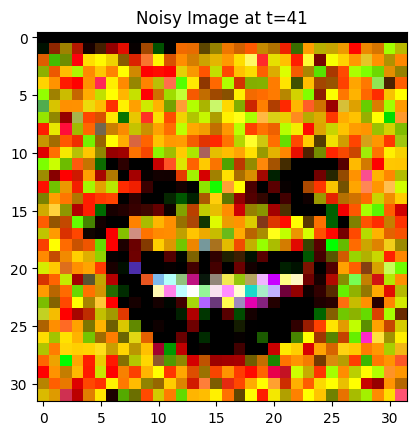

Epoch 8: 100%|██████████| 157/157 [00:07<00:00, 21.34it/s]


Epoch 8, Average Loss: 0.052255


Epoch 9: 100%|██████████| 157/157 [00:07<00:00, 21.41it/s]

Epoch 9, Average Loss: 0.050152


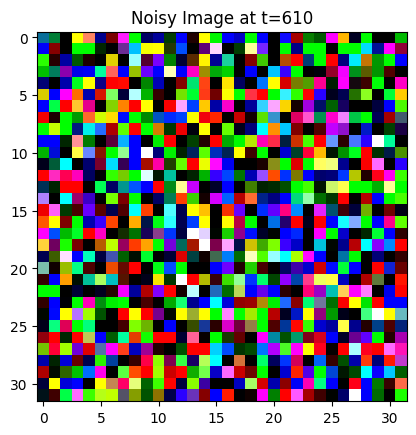

Epoch 10: 100%|██████████| 157/157 [00:07<00:00, 21.02it/s]

Epoch 10, Average Loss: 0.043868


In [ ]:
# Initialize Model and Training Setup
model = ConditionalUNet().to(device)
diffusion = DiffusionModel()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()  # Changed from L1Loss to MSELoss

# Training Loop with Debugging
for epoch in range(10):
    model.train()
    epoch_loss = 0  # Track total loss per epoch
    for embeddings, images in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images, embeddings = images.to(device), embeddings.to(device)
        t = torch.randint(0, 1000, (images.shape[0],), dtype=torch.long).to(device)
        noisy_images, noise = diffusion.add_noise(images, t)
        
        optimizer.zero_grad()
        predicted_noise = model(noisy_images, embeddings)
        loss = loss_fn(predicted_noise, noise)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.6f}")  # Print loss

    # 🔹 Debug: Visualize Noisy Image Every 2 Epochs
    if epoch % 2 == 0:
        sample_idx = 0  # Pick first sample in batch
        plt.imshow(noisy_images[sample_idx].cpu().permute(1, 2, 0).clamp(0, 1).numpy())
        plt.title(f"Noisy Image at t={t[sample_idx].item()}")
        plt.show()


In [7]:
# Load Model and Generate Images
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

num_samples = 10
text_embeddings = torch.randn(num_samples, 384).to(device)  # Ensure correct size
sampled_emojis = sample_emoji(model, diffusion, text_embeddings, num_samples)

# Ensure values are properly scaled
sampled_emojis = sampled_emojis.permute(0, 2, 3, 1)  # Change shape to (N, H, W, C)
sampled_emojis = sampled_emojis.clamp(0, 1)  # Ensure values are between 0 and 1

# Plot Samples
fig, axes = plt.subplots(10, 5, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    if i < num_samples:
        ax.imshow(sampled_emojis[i].cpu().numpy())  # Convert to NumPy before plotting
    ax.axis("off")
plt.show()



NameError: name 'sample_emoji' is not defined

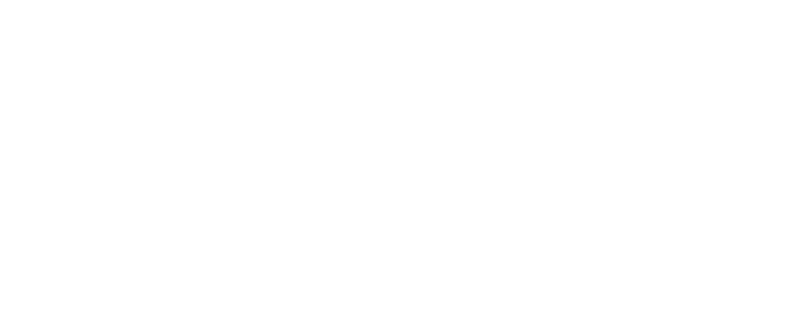

: 

In [ ]:
# Define Sampling Function
def sample_emoji(model, diffusion, text_embeddings, num_samples):
    shape = (num_samples, 3, 32, 32)
    sampled_images = diffusion.sample(model, shape, text_embeddings)
    return sampled_images

# Load Model and Generate Images
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

num_samples = 10
text_embeddings = torch.randn(num_samples, 384).to(device)
sampled_emojis = sample_emoji(model, diffusion, text_embeddings, num_samples)

# Normalize Images for Display
sampled_emojis = (sampled_emojis - sampled_emojis.min()) / (sampled_emojis.max() - sampled_emojis.min() + 1e-8)
sampled_emojis = sampled_emojis.clamp(0, 1)

# Plot Samples
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    if i < num_samples:
        ax.imshow(sampled_emojis[i].cpu().permute(1, 2, 0).numpy())
    ax.axis("off")
plt.show()